In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

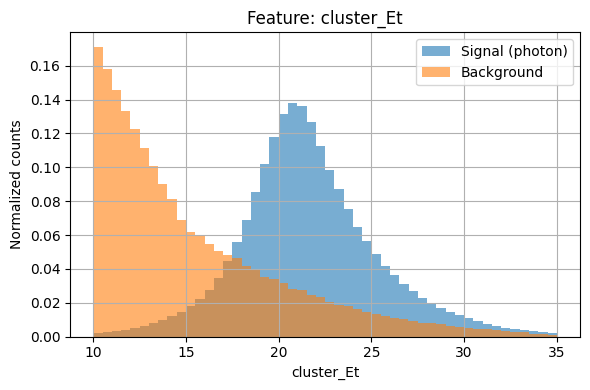

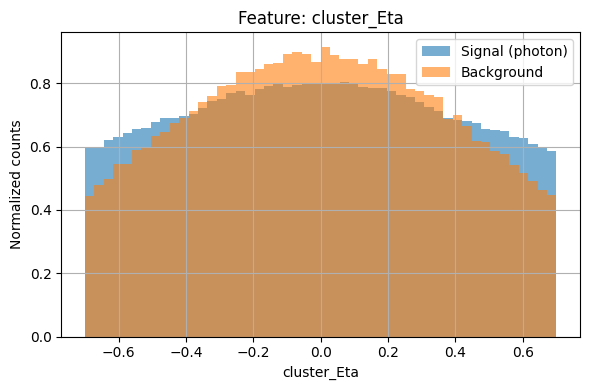

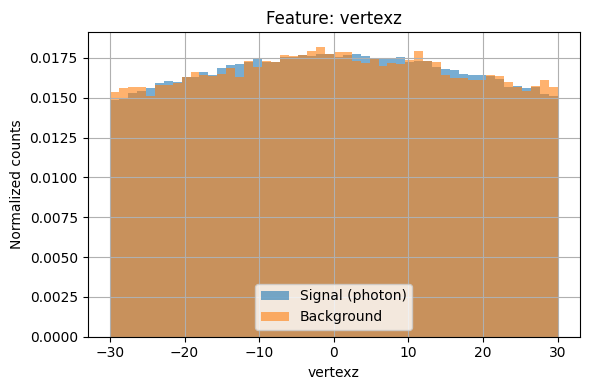

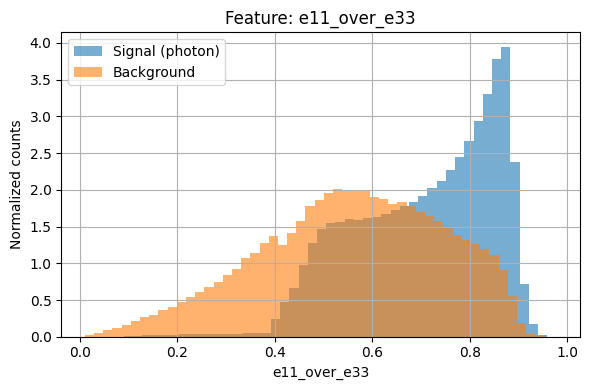

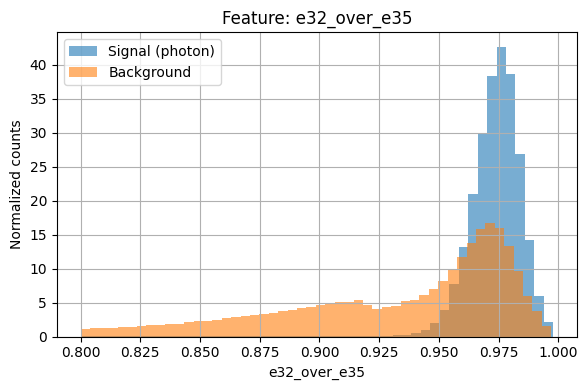

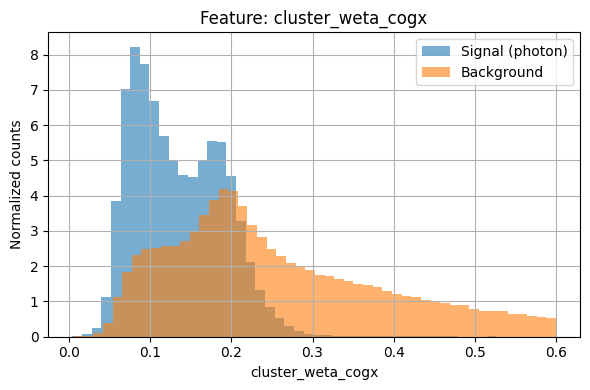

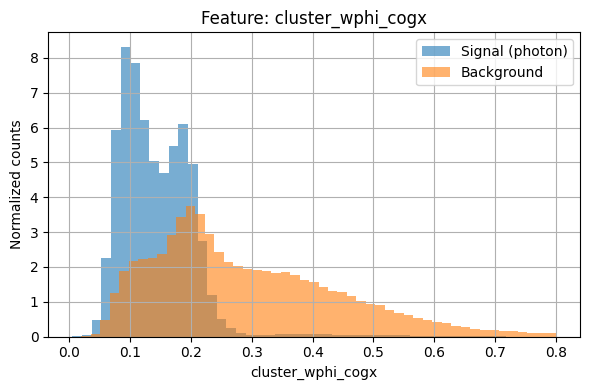

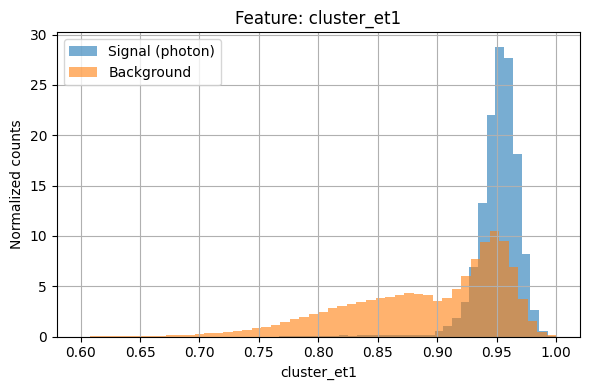

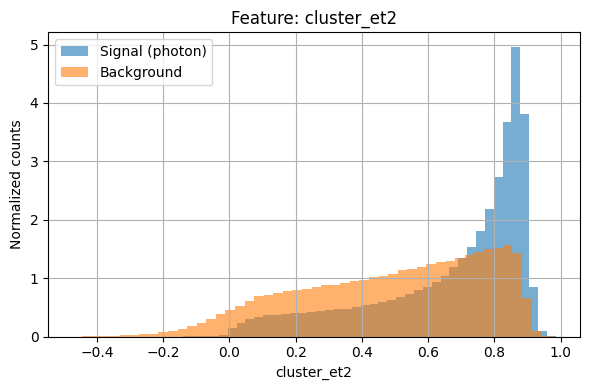

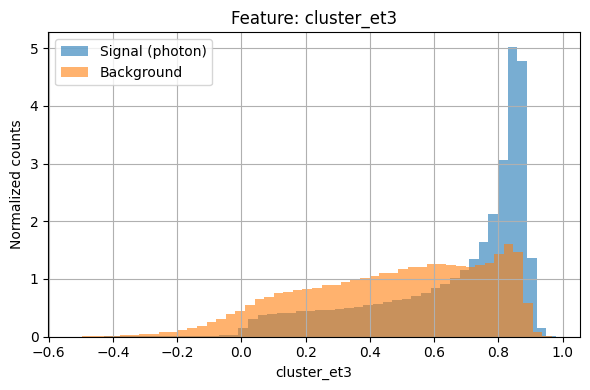

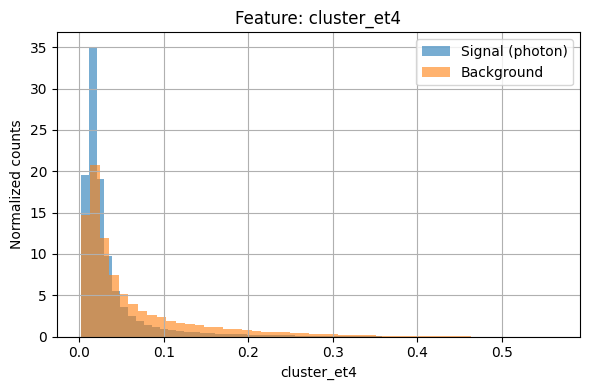

In [81]:
columns = [
    "cluster_Et", "cluster_Eta", "cluster_Phi", "vertexz",
    "e11_over_e33", "e32_over_e35",
    "cluster_prob", "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
    "is_tight", "pid"
]

# Load signal and background
df_sig = pd.read_csv("shapes_photon20.txt", sep=r"\s+", header=0, names=columns)
df_bkg = pd.read_csv("shapes_jet30.txt", sep=r"\s+", header=0, names=columns)

# Convert pid to numeric and filter
df_sig["pid"] = pd.to_numeric(df_sig["pid"], errors="coerce")
df_bkg["pid"] = pd.to_numeric(df_bkg["pid"], errors="coerce")

# Keep only photons for signal, and reject electrons for background
df_sig = df_sig[df_sig["pid"] == 22]  # photon only

df_bkg = df_bkg[~df_bkg["pid"].isin([11, -11])]  # remove electrons/positrons
#df_bkg = df_bkg[df_bkg["cluster_Et"] > 10]

# Assign labels
df_sig["label"] = 1
df_bkg["label"] = 0

# Combine
df = pd.concat([df_sig, df_bkg], ignore_index=True)

# Define features to use
features = [
    "cluster_Et", "cluster_Eta", "vertexz", "e11_over_e33", "e32_over_e35",
    "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
]

# Convert all features to numeric and drop invalid rows
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.dropna(subset=features + ["label"], inplace=True)





for col in features:
    plt.figure(figsize=(6, 4))
    bins = 50

    plt.hist(df[df["label"] == 1][col], bins=bins, alpha=0.6, label="Signal (photon)", density=True, histtype='stepfilled')
    plt.hist(df[df["label"] == 0][col], bins=bins, alpha=0.6, label="Background", density=True, histtype='stepfilled')

    plt.xlabel(col)
    plt.ylabel("Normalized counts")
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

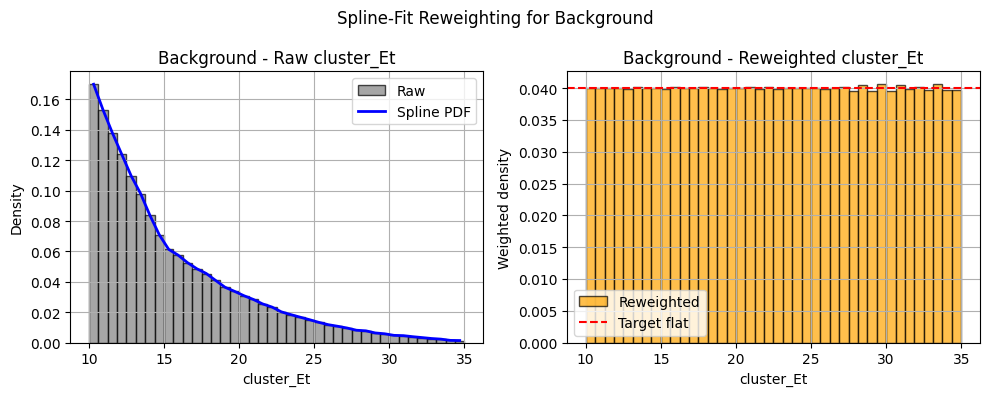

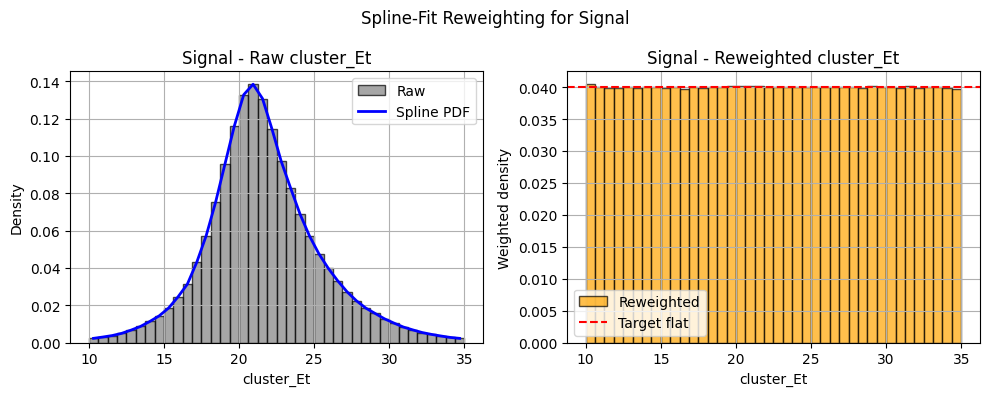

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Parameters
et_min, et_max = 10, 35
n_bins = 40
bin_width = (et_max - et_min)/n_bins
bins = np.linspace(et_min, et_max, n_bins + 1)
et_centers = 0.5 * (bins[:-1] + bins[1:])

df_weighted = df.copy()

for label in [0, 1]:
    label_name = "Background" if label == 0 else "Signal"
    mask = df["label"] == label
    values = df.loc[mask, "cluster_Et"].values

    # --- Step 1: Histogram for PDF estimation ---
    hist, bin_edges = np.histogram(values, bins=bins, density=True)
    x_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # --- Step 2: Fit Spline to Histogram ---
    spline = UnivariateSpline(x_centers, hist, s=0.0)  # s controls smoothing
    pdf_vals = spline(values)
    pdf_vals = np.clip(pdf_vals, a_min=1e-3, a_max=None)  # avoid division by zero

    # --- Step 3: Inverse-PDF weights ---
    weights = 1.0 / pdf_vals
    weights /= np.mean(weights)  # optional normalization
    if label == 1:
        #class balance
        weights = weights * 10

    # --- Store weights ---
    df_weighted.loc[mask, "weight"] = weights

    # --- QA Plots ---
    plt.figure(figsize=(10, 4))

    # Before weighting
    plt.subplot(1, 2, 1)
    plt.hist(values, bins=bins, density=True, alpha=0.7, color="gray", edgecolor="black", label="Raw")
    plt.plot(x_centers, spline(x_centers), label="Spline PDF", lw=2, color="blue")
    plt.title(f"{label_name} - Raw cluster_Et")
    plt.xlabel("cluster_Et")
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend()

    # After weighting
    plt.subplot(1, 2, 2)
    plt.hist(values, bins=bins, weights=weights, density=True, alpha=0.7, color="orange", edgecolor="black", label="Reweighted")
    plt.axhline(1.0/n_bins/bin_width, color="red", linestyle="--", label="Target flat")
    plt.title(f"{label_name} - Reweighted cluster_Et")
    plt.xlabel("cluster_Et")
    plt.ylabel("Weighted density")
    plt.grid(True)
    plt.legend()

    plt.suptitle(f"Spline-Fit Reweighting for {label_name}")
    plt.tight_layout()
    plt.show()

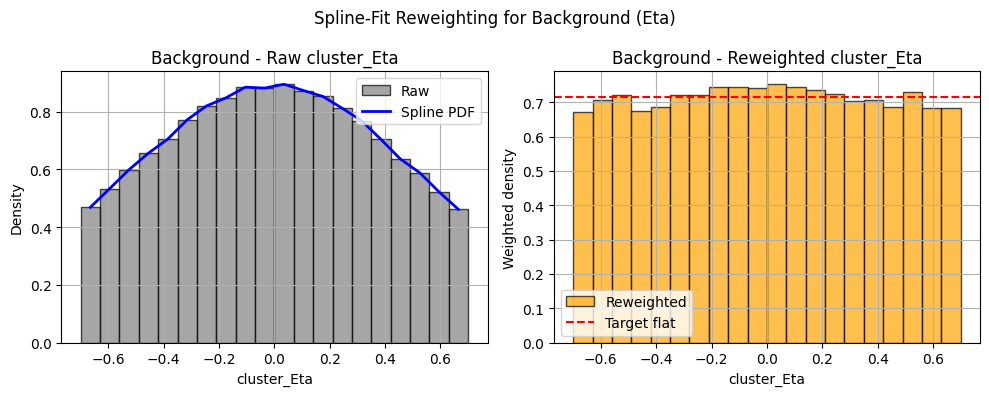

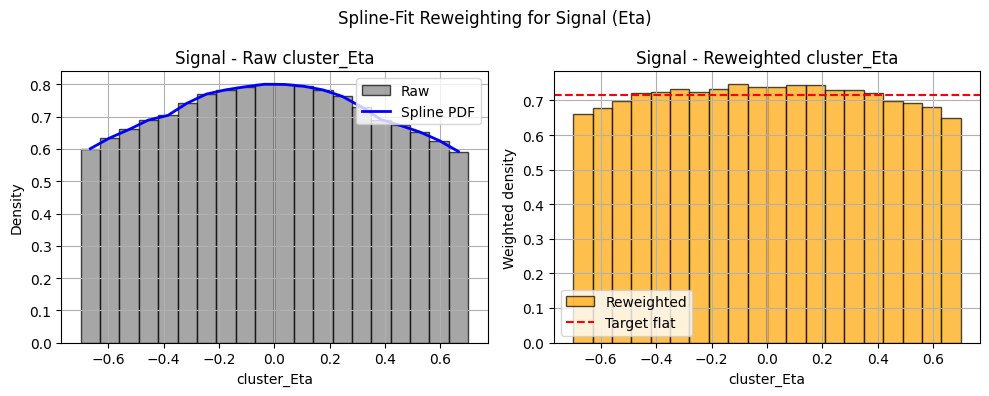

In [83]:
# Parameters for cluster_Eta
eta_min, eta_max = -0.7, 0.7
n_bins_eta = 20
bin_width_eta = (eta_max - eta_min) / n_bins_eta
bins_eta = np.linspace(eta_min, eta_max, n_bins_eta + 1)
eta_centers = 0.5 * (bins_eta[:-1] + bins_eta[1:])

# Flatten Eta distribution on top of Et weights
for label in [0, 1]:
    label_name = "Background" if label == 0 else "Signal"
    mask = df["label"] == label
    eta_vals = df.loc[mask, "cluster_Eta"].values

    # Histogram for eta PDF
    hist_eta, bin_edges_eta = np.histogram(eta_vals, bins=bins_eta, density=True)
    x_centers_eta = 0.5 * (bin_edges_eta[:-1] + bin_edges_eta[1:])

    # Fit spline to eta PDF
    spline_eta = UnivariateSpline(x_centers_eta, hist_eta, s=0.0)
    pdf_eta_vals = spline_eta(eta_vals)
    pdf_eta_vals = np.clip(pdf_eta_vals, a_min=1e-3, a_max=None)

    # Compute inverse PDF weights for eta
    weights_eta = 1.0 / pdf_eta_vals
    weights_eta /= np.mean(weights_eta)

    # Multiply with existing Et weights
    if label == 1:
        weights_eta *= 10  # for class balancing, if done in Et step too

    # Combine: total weight = weight_Et * weight_eta
    df_weighted.loc[mask, "weight"] *= weights_eta

    # QA plots
    plt.figure(figsize=(10, 4))

    # Before weighting
    plt.subplot(1, 2, 1)
    plt.hist(eta_vals, bins=bins_eta, density=True, alpha=0.7, color="gray", edgecolor="black", label="Raw")
    plt.plot(x_centers_eta, spline_eta(x_centers_eta), label="Spline PDF", lw=2, color="blue")
    plt.title(f"{label_name} - Raw cluster_Eta")
    plt.xlabel("cluster_Eta")
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend()

    # After weighting
    plt.subplot(1, 2, 2)
    plt.hist(eta_vals, bins=bins_eta, weights=df_weighted.loc[mask, "weight"], density=True,
             alpha=0.7, color="orange", edgecolor="black", label="Reweighted")
    plt.axhline(1.0/n_bins_eta/bin_width_eta, color="red", linestyle="--", label="Target flat")
    plt.title(f"{label_name} - Reweighted cluster_Eta")
    plt.xlabel("cluster_Eta")
    plt.ylabel("Weighted density")
    plt.grid(True)
    plt.legend()

    plt.suptitle(f"Spline-Fit Reweighting for {label_name} (Eta)")
    plt.tight_layout()
    plt.show()


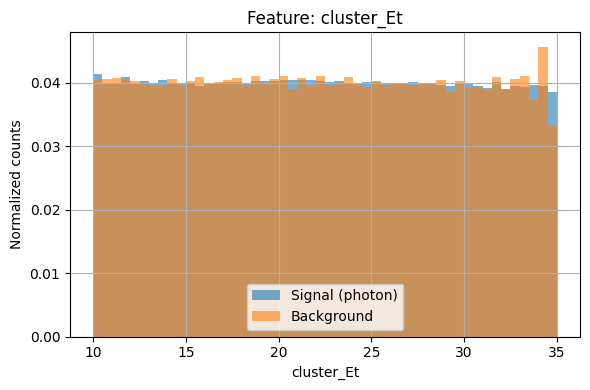

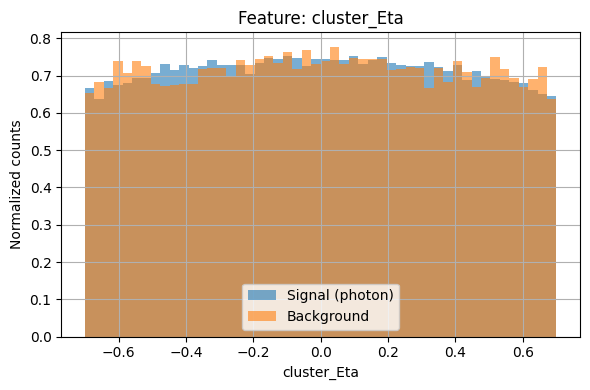

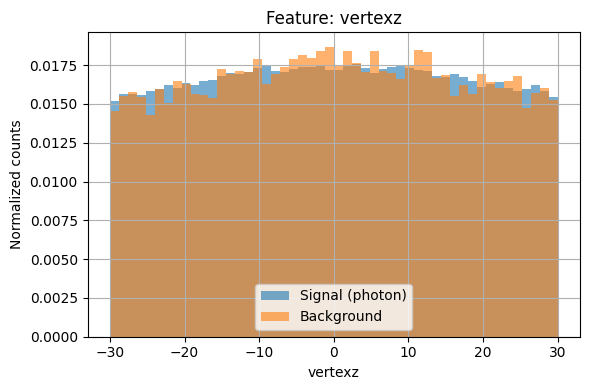

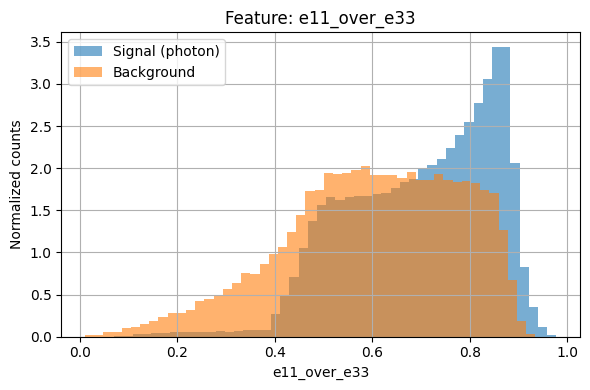

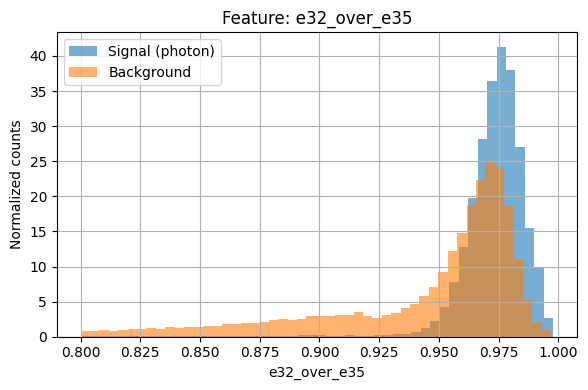

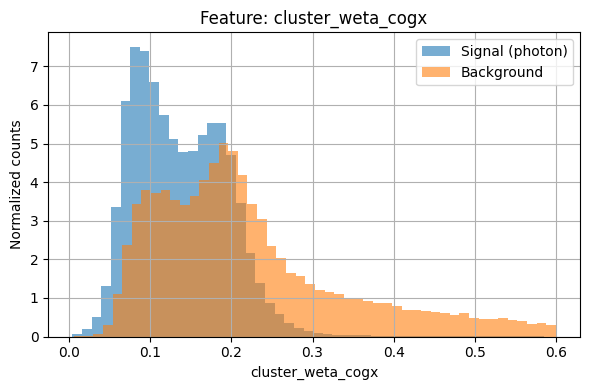

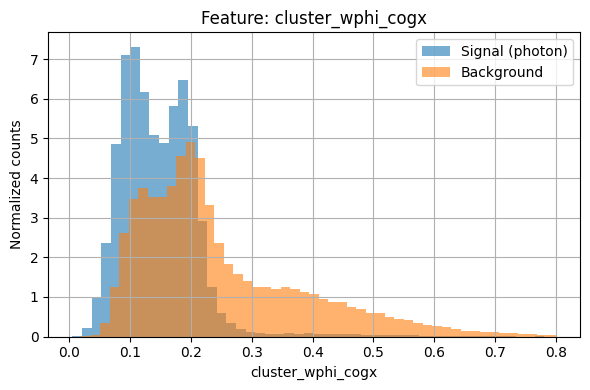

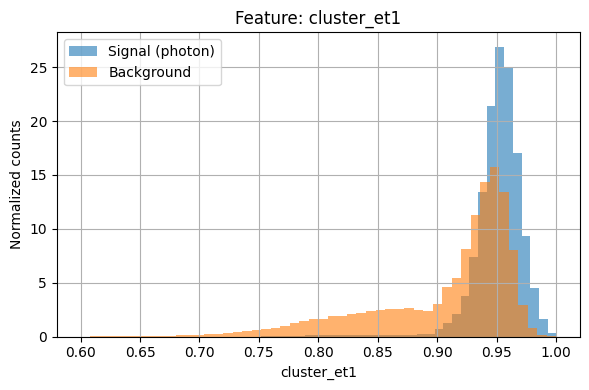

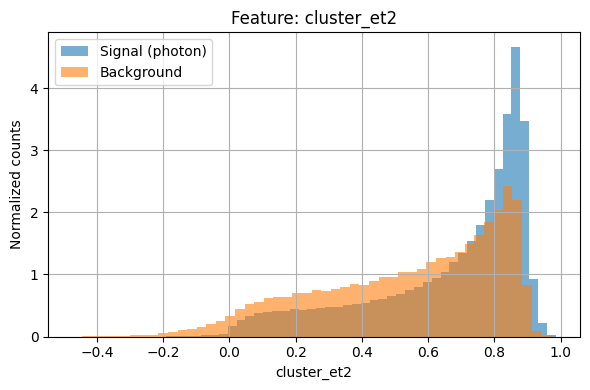

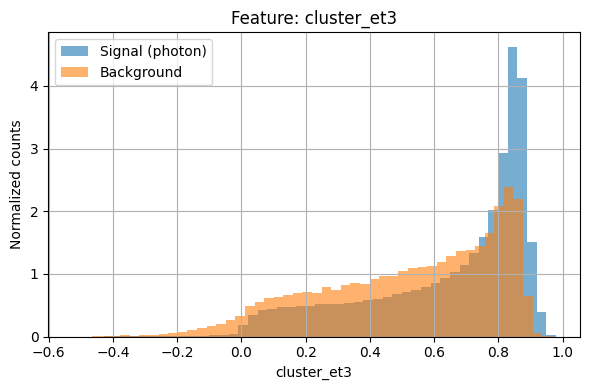

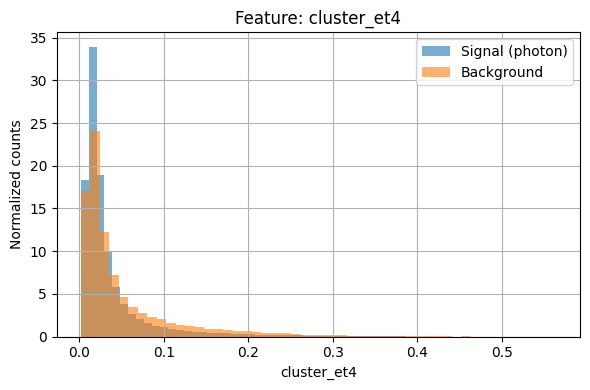

In [84]:
for col in features:
    plt.figure(figsize=(6, 4))
    bins = 50

    mask_sig = df_weighted["label"] == 1
    mask_bkg = df_weighted["label"] == 0

    plt.hist(df_weighted.loc[mask_sig, col], bins=bins,
             weights=df_weighted.loc[mask_sig, "weight"],
             alpha=0.6, label="Signal (photon)",
             density=True, histtype='stepfilled')

    plt.hist(df_weighted.loc[mask_bkg, col], bins=bins,
             weights=df_weighted.loc[mask_bkg, "weight"],
             alpha=0.6, label="Background",
             density=True, histtype='stepfilled')

    plt.xlabel(col)
    plt.ylabel("Normalized counts")
    plt.title(f"Feature: {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Label counts: {np.int32(0): np.int64(151034), np.int32(1): np.int64(958105)}
[[  6237  31522]
 [    47 239479]]
              precision    recall  f1-score   support

           0       0.99      0.17      0.28     37759
           1       0.88      1.00      0.94    239526

    accuracy                           0.89    277285
   macro avg       0.94      0.58      0.61    277285
weighted avg       0.90      0.89      0.85    277285



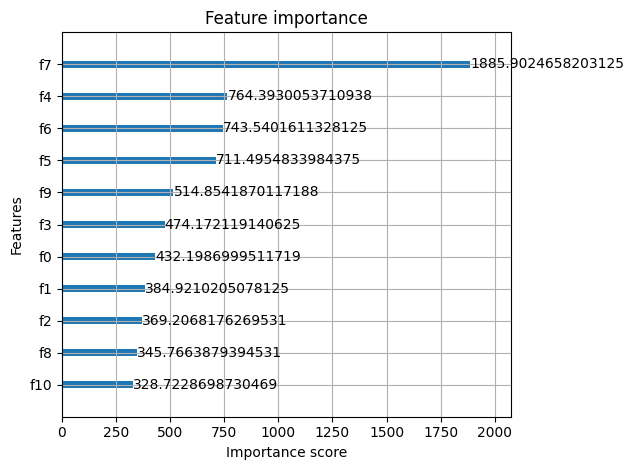

In [85]:
X = df_weighted[features].to_numpy(dtype=np.float32) 
y = df_weighted["label"].to_numpy(dtype=np.int32)
w = df_weighted["weight"].to_numpy(dtype=np.float32) 

# Step 4: Train/test split (returns NumPy arrays)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=42, stratify=y
)

# label distribution check
unique, counts = np.unique(y_train, return_counts=True)
print("Label counts:", dict(zip(unique, counts)))


# Step 5: Train a BDT with XGBoost
model = xgb.XGBClassifier(
    max_depth=5,              # try 2–10
    n_estimators=300,         # more trees, pair with lower learning rate
    learning_rate=0.05,       # try 0.01–0.3
    subsample=0.8,            # randomly sample 80% of training examples per tree
    colsample_bytree=0.8,     # randomly sample 80% of features per tree
    gamma=1,                  # min loss reduction to split, helps prune
    reg_alpha=1,              # L1 regularization on weights
    reg_lambda=1,             # L2 regularization on weights
    eval_metric='auc',
)
model.fit(X_train, y_train, sample_weight=w_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: Feature importance plot
import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='gain')
plt.tight_layout()
plt.show()

import ROOT
ROOT.TMVA.Experimental.SaveXGBoost(          # pythonized helper
        model,                  # xgboost.Booster
        "myBDT",                        
        "myBDT.root",
        num_inputs=11)


--- BDT score summary ---
 Signal:   n= 239526   mean=0.998   min=0.000   max=1.000
 Bkgd:     n=  37759   mean=0.808   min=0.000   max=1.000


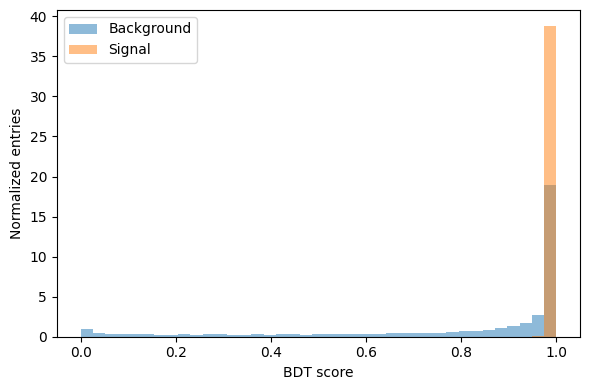

In [86]:
# ---------------------------------------------------------------
# Block 7 – Inspect BDT scores for signal vs. background
# ---------------------------------------------------------------

# 1. Continuous BDT scores (probability for class 1)
score_test = model.predict_proba(X_test)[:, 1]   # shape (N_test,)

# 2. Split by truth label
sig_mask = y_test == 1
bkg_mask = y_test == 0

sig_scores = score_test[sig_mask]
bkg_scores = score_test[bkg_mask]

# 3. Quick numerical summary
import numpy as np
print("\n--- BDT score summary ---")
print(f" Signal:   n={sig_scores.size:7d}   mean={sig_scores.mean():.3f}   "
      f"min={sig_scores.min():.3f}   max={sig_scores.max():.3f}")
print(f" Bkgd:     n={bkg_scores.size:7d}   mean={bkg_scores.mean():.3f}   "
      f"min={bkg_scores.min():.3f}   max={bkg_scores.max():.3f}")

# 4. Optional: overlaid histograms
import matplotlib.pyplot as plt
bins = np.linspace(0, 1, 40)  # 0–1 probability range

plt.figure(figsize=(6,4))
plt.hist(bkg_scores, bins=bins, alpha=0.5, label="Background", density=True)
plt.hist(sig_scores, bins=bins, alpha=0.5, label="Signal",     density=True)
plt.xlabel("BDT score")
plt.ylabel("Normalized entries")
plt.legend()
plt.tight_layout()
plt.show()


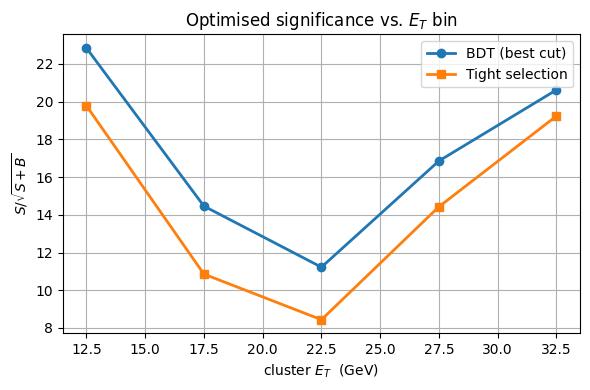

In [79]:
# ---------------------------------------------------------------
# Block ➊ – compute max-BDT and tight-cut significance per Et bin
# ---------------------------------------------------------------
import numpy as np

bin_centres      = []
sig_best_bdt     = []   # optimal BDT cut
sig_tight        = []   # fixed tight selection

for i in range(len(et_bins) - 1):
    et_min, et_max = et_bins[i], et_bins[i + 1]
    mask = (df["cluster_Et"] >= et_min) & (df["cluster_Et"] < et_max)
    if mask.sum() < 100:
        continue

    y_bin      = y[mask]                                # 0 / 1
    scores_bin = model.predict_proba(X[mask])[:, 1]
    tight_bin  = df.loc[mask, "is_tight"].to_numpy(dtype=np.int8)

    # --- 1. scan score thresholds for BDT
    best = 0.0
    thr  = np.linspace(0, 1, 201)
    for t in thr:
        S = np.sum((scores_bin >= t) & (y_bin == 1))
        B = np.sum((scores_bin >= t) & (y_bin == 0))
        if S + B:
            z = S / np.sqrt(S + B)
            if z > best:
                best = z
    sig_best_bdt.append(best)

    # --- 2. significance for *tight* flag
    S_t = np.sum((tight_bin == 1) & (y_bin == 1))
    B_t = np.sum((tight_bin == 1) & (y_bin == 0))
    z_t = S_t / np.sqrt(S_t + B_t) if (S_t + B_t) else 0.0
    sig_tight.append(z_t)

    bin_centres.append(0.5 * (et_min + et_max))

# ---------------------------------------------------------------
# Block ➋ – overlay plot
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(bin_centres, sig_best_bdt, marker="o", lw=2,
         label="BDT (best cut)")
plt.plot(bin_centres, sig_tight, marker="s", lw=2,
         label="Tight selection")
plt.xlabel(r"cluster $E_T$  (GeV)")
plt.ylabel(r"$S/\sqrt{S+B}$")
plt.title("Optimised significance vs. $E_T$ bin")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


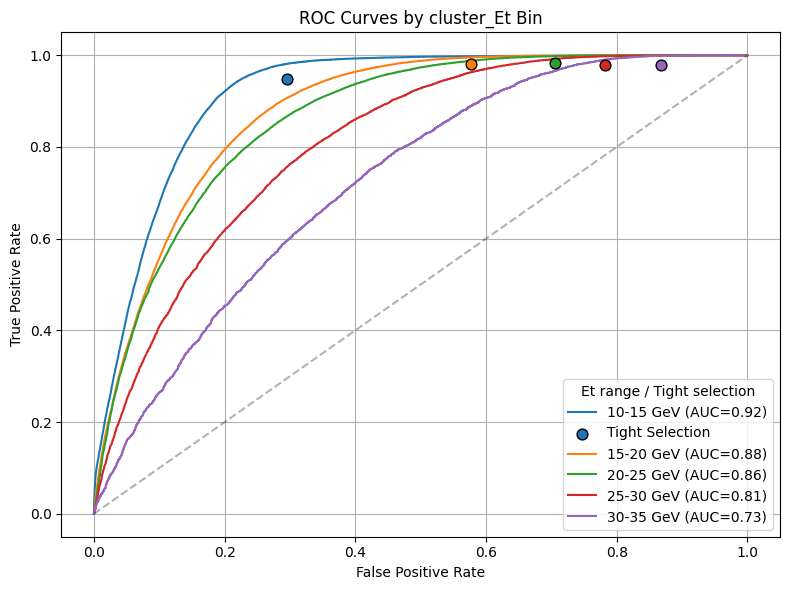

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define Et bins
et_bins = [10, 15, 20, 25, 30, 35]

# Start the plot
plt.figure(figsize=(8, 6))

# Flag to add tight legend only once
tight_legend_added = False

for i in range(len(et_bins) - 1):
    et_min = et_bins[i]
    et_max = et_bins[i + 1]

    mask = (df["cluster_Et"] >= et_min) & (df["cluster_Et"] < et_max)
    if mask.sum() < 100:
        continue

    X_bin = df.loc[mask, features]
    y_bin = df.loc[mask, "label"]
    tight_bin = df.loc[mask, "is_tight"].astype(int)

    bdt_probs = model.predict_proba(X_bin)[:, 1]

    fpr_bdt, tpr_bdt, _ = roc_curve(y_bin, bdt_probs)
    auc_bdt = auc(fpr_bdt, tpr_bdt)

    # Plot ROC curve and extract color
    line, = plt.plot(fpr_bdt, tpr_bdt, label=f"{et_min}-{et_max} GeV (AUC={auc_bdt:.2f})")
    roc_color = line.get_color()

    # Tight point
    fpr_tight, tpr_tight, _ = roc_curve(y_bin, tight_bin)
    plt.scatter(
        fpr_tight[1], tpr_tight[1],
        color=roc_color, edgecolor='black', s=60,
        label="Tight Selection" if not tight_legend_added else None,
        zorder=5
    )
    tight_legend_added = True  # only label the first time

# Reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by cluster_Et Bin")
plt.legend(title="Et range / Tight selection", loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
model.save_model("bdt.json") 

In [33]:
import ROOT
ROOT.TMVA.Experimental.SaveXGBoost(          # pythonized helper
        model,                  # xgboost.Booster
        "myBDT",                        
        "myBDT.root",
        num_inputs=11)